## ECHR Dataset - Component Classification results

This notebook contains functions to measure the performance of a classifier applied over a set of annotations.

The output of the classification files is expected to be compatible with the output of the UKPLab models. Each line contains the token, the true label, and predicted label of one classification example, in that order, separated by tabs. The first row has the columns names. For example:

`word_n    I-Premise:2:Support    I-Premise:-1:Support`

Training results must be stored in tsv format with the following columns: epoch, modelName, dev_score, test_score, max_dev_score, max_test_score

In [56]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import pandas
import pickle
import os
import re
import seaborn as sns
from sklearn import metrics

import colors
import learning_metrics
import performance_metrics
import visualizations

In [105]:
import importlib
importlib.reload(colors)
importlib.reload(learning_metrics)
importlib.reload(performance_metrics)
importlib.reload(visualizations)

<module 'visualizations' from '/home/mteruel/am/argument_mining/evaluation/visualizations.py'>

In [11]:
CC_EXPERIMENTS_DIRS = [
    ## Exploration # No attention
#     '../../results/ukpnets/paragraph/18-11-14-14-49',
#     '../../results/ukpnets/paragraph/18-11-14-16-39',
#     '../../results/ukpnets/paragraph/18-11-14-18-15',
#     '../../results/ukpnets/paragraph/18-11-14-20-17',
#     '../../results/ukpnets/paragraph/18-11-14-22-02',
#     ## Exploration, word attention with sigmoid
#     '../../results/ukpnets/paragraph/18-11-14-22-22',
#     '../../results/ukpnets/paragraph/18-11-15-00-38',
#     '../../results/ukpnets/paragraph/18-11-15-02-17',
#     '../../results/ukpnets/paragraph/18-11-15-04-16',
#     '../../results/ukpnets/paragraph/18-11-15-06-01',
#     ## Exploration, word attention with None
#     '../../results/ukpnets/paragraph/18-11-15-09-54',
#     '../../results/ukpnets/paragraph/18-11-15-11-16',
#     '../../results/ukpnets/paragraph/18-11-15-13-21',
#     '../../results/ukpnets/paragraph/18-11-15-16-07',
#     '../../results/ukpnets/paragraph/18-11-15-17-58',
#     '../../results/ukpnets/paragraph/18-11-15-20-05',
#     '../../results/ukpnets/paragraph/18-11-15-21-15',
#     '../../results/ukpnets/paragraph/18-11-15-22-29',
#     '../../results/ukpnets/paragraph/18-11-16-00-25',
#     '../../results/ukpnets/paragraph/18-11-16-02-25',
#     '../../results/ukpnets/paragraph/18-11-16-03-52',
#     '../../results/ukpnets/paragraph/18-11-16-06-46',
    
    # '../../results/ukpnets/paragraph/18-11-15-10-16/',  # Time sigmoid not optimal
#     '../../results/ukpnets/paragraph/18-11-15-18-37/',  # Final time sigmoid
    
    # Exploration feature sigmoid
#     '../../results/ukpnets/paragraph/18-11-16-10-08',
#     '../../results/ukpnets/paragraph/18-11-16-14-01',
#     '../../results/ukpnets/paragraph/18-11-16-18-28',
#     '../../results/ukpnets/paragraph/18-11-16-22-24',
#     '../../results/ukpnets/paragraph/18-11-17-03-00',
    
    # Exploration feature tanh
#     '../../results/ukpnets/paragraph/18-11-17-06-54',
#     '../../results/ukpnets/paragraph/18-11-17-10-36',
#     '../../results/ukpnets/paragraph/18-11-17-13-57',
#     '../../results/ukpnets/paragraph/18-11-17-18-36',
#     '../../results/ukpnets/paragraph/18-11-17-22-40',
#     # Exploration feature none
#     '../../results/ukpnets/paragraph/18-11-18-02-37',
#     '../../results/ukpnets/paragraph/18-11-18-06-04',
#     '../../results/ukpnets/paragraph/18-11-18-09-54',
#     '../../results/ukpnets/paragraph/18-11-18-13-06',
#     '../../results/ukpnets/paragraph/18-11-18-16-32',
    
    '../../results/ukpnets/paragraph/18-11-19-13-13',
    '../../results/ukpnets/paragraph/18-11-19-14-12/',
]

## Classification Results

In [37]:
echr_extra_keys = {
    'Partition': lambda prediction_file: re.search('.*partition(\d+).*', prediction_file).group(1)
}

In [55]:
cc_results = performance_metrics.architecture_metrics(CC_EXPERIMENTS_DIRS, keys=echr_extra_keys)
cc_results[:3]

,Classifier,Dataset,Accuracy,Precision,Recall,F1-Score,Support,Partition
0,18-11-19-13-13,test,0.567186,0.425690,0.380617,0.354341,11751,1
1,18-11-19-13-13,dev,0.710886,0.591328,0.556656,0.558827,4244,7
2,18-11-19-13-13,dev,0.660619,0.594932,0.511414,0.526967,4685,0


### Comparison between classifiers

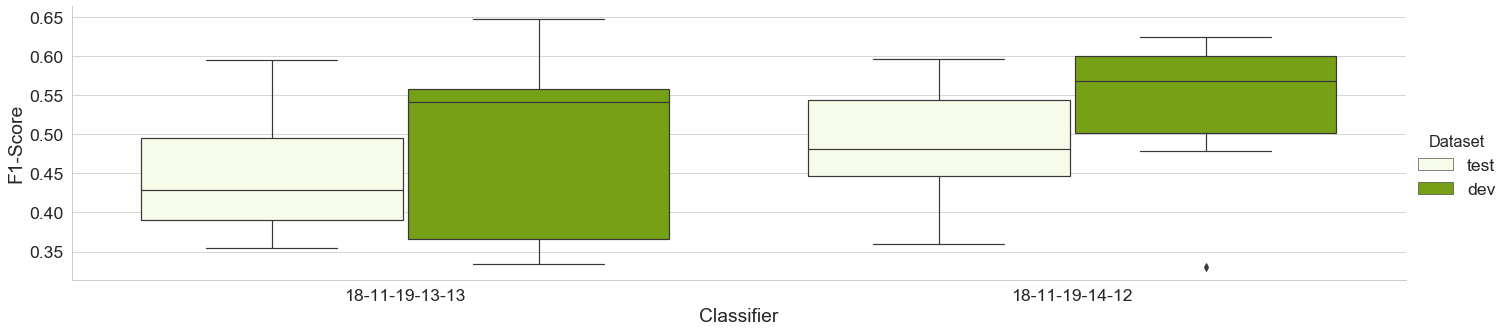

In [39]:
sns.catplot(data=cc_results,
            x='Classifier', kind='box', y='F1-Score', hue='Dataset',
            aspect=4, height=5, color=colors.green)

In [26]:
cc_results_stacked_metrics = cc_results.drop(columns='Support').set_index(
    ['Classifier', 'Dataset', 'Partition']).stack().reset_index().rename(
    columns={0: 'Metric Value', 'level_3': 'Metric'})

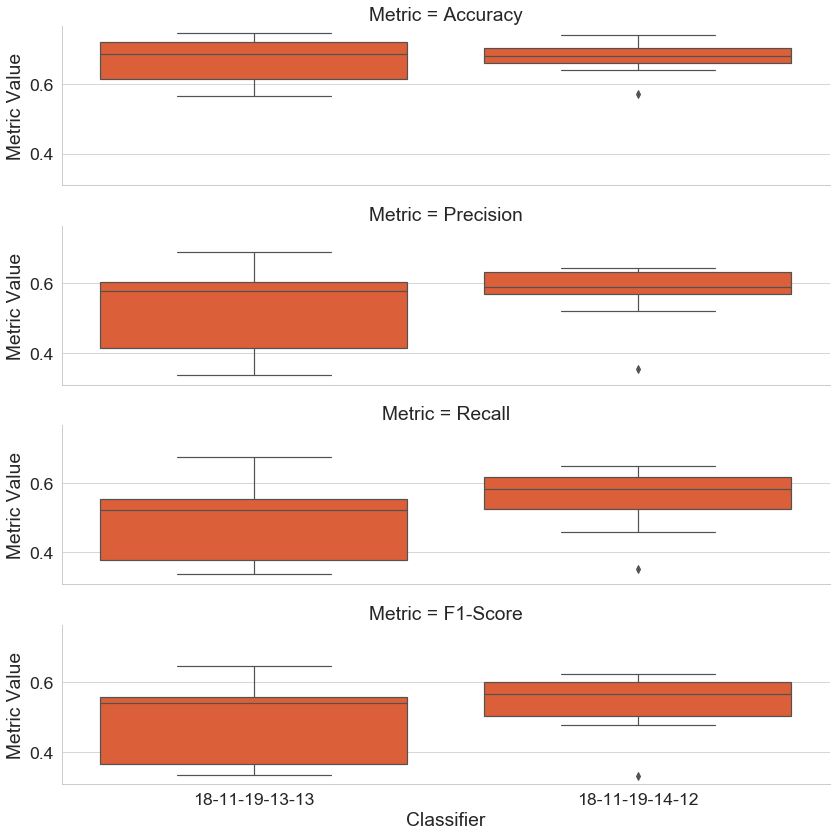

In [35]:
sns.catplot(data=cc_results_stacked_metrics[cc_results_stacked_metrics.Dataset == 'dev'],
            x='Classifier', kind='box', y='Metric Value', row='Metric',
            aspect=4, height=3, color=colors.red)

## Learning rate

In [81]:
cc_learning = learning_metrics.architecture_learning(CC_EXPERIMENTS_DIRS, keys=echr_extra_keys)
cc_learning[:4]

,epoch,Dataset,Metric Value,Classifier,Partition
0,1,dev,0.344233,18-11-19-13-13,0
1,1,test,0.354626,18-11-19-13-13,0
2,2,dev,0.360917,18-11-19-13-13,0
3,2,test,0.371213,18-11-19-13-13,0


In [47]:
hyperparameters = pandas.read_csv('../../results/ukpnets/echr_classifiers.tsv', sep='\t',
                                  usecols=['Name', 'Time/Feature', 'Activation', 'Attention'])
hyperparameters = hyperparameters.rename(columns={'Time/Feature': 'Attention type', 'Name': 'Classifier'})
hyperparameters = hyperparameters.replace(
    to_replace=['Word', 'Context'], value=['Word attention', 'Context attention'])
hyperparameters['Attention type'] = hyperparameters['Attention type'].replace('None', 'No attention')
hyperparameters['Activation'] = hyperparameters['Activation'].replace('None', 'Linear')
hyperparameters[:3]

,Classifier,Attention type,Activation,Attention
0,18-11-14-14-49,No attention,Linear,No
1,18-11-14-16-39,No attention,Linear,No
2,18-11-14-18-15,No attention,Linear,No


In [51]:
cc_learning = cc_learning.join(hyperparameters.set_index('Classifier'), on='Classifier')

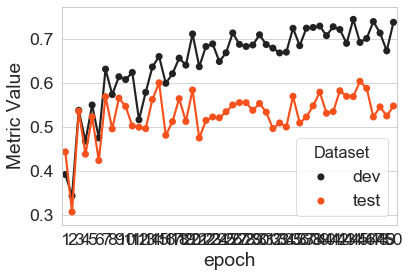

In [100]:
sns.pointplot(data=cc_learning[(cc_learning.Classifier == '18-11-19-13-13') & (cc_learning.Partition == '4')],
              x='epoch', y='Metric Value', hue='Dataset',
              aspect=6, join=True,
              color=colors.red)

### Confusion matrix

/home/mteruel/anaconda2/envs/env35/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mteruel/anaconda2/envs/env35/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mteruel/anaconda2/envs/env35/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

     B-claim       0.00      0.00      0.00        83
   B-premise       0.00      0.00      0.00        75
     I-claim       0.65      0.63      0.64      2461
   I-premise       0.54      0.43      0.48      1903
           O       0.49      0.69      0.57      1470

   micro avg       0.57      0.57      0.57      5992
   macro avg       0.34      0.35      0.34      5992
weighted avg       0.56      0.57      0.56      5992

5992


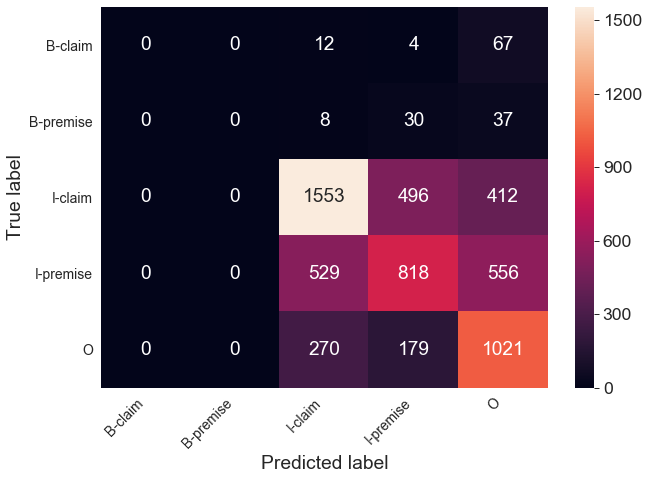

In [110]:
performance_metrics.plot_confusion_matrix(CC_EXPERIMENTS_DIRS[0], partition=6)